In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import scipy.stats as stats
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
plt.rc('font', family='Malgun Gothic')

In [3]:
independent_variable_path = "DATA/독립변수/independent_var.csv"  
station_with_store_count_path = "DATA/독립변수/station_with_store_count.csv." 
crowded_path = "DATA/종속변수/crowded.csv"  
personnel_time_path = "DATA/종속변수/personnel_time.xlsx"  
personnel_total_path = "DATA/종속변수/personnel_total.csv"  

independent_variable = pd.read_csv(independent_variable_path, index_col=0)
station_with_store_count = pd.read_csv(station_with_store_count_path)  
crowded = pd.read_csv(crowded_path, index_col=0) 
personnel_time = pd.read_excel(personnel_time_path, index_col=0)
personnel_total = pd.read_csv(personnel_total_path, index_col=0)  

In [4]:
independent_variable.reset_index(inplace=True)
independent_variable.rename(columns={'index': '역명'}, inplace=True)

In [5]:
crowded = crowded.reset_index()
personnel_time = personnel_time.reset_index()
personnel_total = personnel_total.reset_index()

In [6]:
crowded.rename(columns={crowded.columns[0]: '역명'}, inplace=True)
personnel_time.rename(columns={personnel_time.columns[0]: '역명'}, inplace=True)
personnel_total.rename(columns={personnel_total.columns[0]: '역명'}, inplace=True)

In [7]:
independent_variable['역명'] = independent_variable['역명'].astype(str)
crowded['역명'] = crowded['역명'].astype(str)
personnel_time['역명'] = personnel_time['역명'].astype(str)
personnel_total['역명'] = personnel_total['역명'].astype(str)

In [8]:
# "보관함 소형", "보관함 중형", "보관함 대형" 칼럼 합쳐서 "물품 보관함 수"로 추가
independent_variable['물품 보관함 수'] = independent_variable['보관함 소형'] + independent_variable['보관함 중형'] + independent_variable['보관함 대형']
independent_variable.drop(columns=['보관함 소형', '보관함 중형', '보관함 대형'], inplace=True)

In [9]:
for column in independent_variable.columns:
    if column != '역명':
        independent_variable[column] = independent_variable[column].replace({',': ''}, regex=True).astype(int)

In [10]:
station_with_store_count = station_with_store_count[['역명', 'restaurant_count', 'convini_count', 'cafe_count']]
station_with_store_count.rename(columns={
    'restaurant_count': '음식점',
    'convini_count': '편의점',
    'cafe_count': '카페'
}, inplace=True)
station_with_store_count = station_with_store_count.sort_values(by='역명', ascending=True)
station_with_store_count = station_with_store_count.reset_index(drop=True)

In [11]:
independent_variable.head(3)

,역명,에스컬레이터 설치 수,버스 정류장 수,경찰서 수,도서관 수,소방서 수,사회복지시설 수,학교 수,구청 수,은행 수,...,사고발생건수,총인구(명),주택 계(호),단독주택(호),아파트(호),연립주택(호),다세대주택(호),비주거용 건물 내 주택(호),주택 이외의 거처 계(호),물품 보관함 수
0,가산디지털단지,14,34,2,2,0,0,0,1,6,...,1,423397,137863,11083,86368,7631,31973,808,17245,26
1,강남구청,7,12,3,3,0,1,0,2,43,...,1,511084,184608,6161,138025,5645,33229,1548,15217,17
2,건대입구,11,8,5,4,0,0,1,3,8,...,2,348160,95286,14861,35072,4173,39797,1383,10161,105


In [12]:
station_with_store_count.head(3)

,역명,음식점,편의점,카페
0,가산디지털단지,248,57,144
1,강남구청,163,28,73
2,건대입구,244,47,126


In [13]:
crowded.head(3)

,역명,5시30분,6시00분,6시30분,7시00분,7시30분,8시00분,8시30분,9시00분,9시30분,...,20시00분,20시30분,21시00분,21시30분,22시00분,22시30분,23시00분,23시30분,00시00분,00시30분
0,가산디지털단지,29.361111,23.600000,23.716667,27.355556,33.355556,37.916667,34.811111,33.622222,32.783333,...,29.838889,29.916667,30.733333,29.477778,28.355556,27.744444,26.338889,15.927778,6.150000,3.100000
1,강남구청,16.550000,28.622222,22.544444,26.572222,34.011111,39.522222,37.072222,40.205556,40.355556,...,37.822222,38.300000,38.855556,36.611111,38.983333,32.933333,26.872222,20.977778,5.261111,3.016667
2,건대입구,23.211111,31.266667,27.027778,33.516667,40.655556,46.172222,44.477778,48.705556,44.777778,...,44.427778,44.655556,46.483333,45.438889,48.672222,39.194444,34.877778,29.172222,7.772222,1.733333


In [14]:
personnel_time.head(3)

,역명,04시-05시,05시-06시,06시-07시,07시-08시,08시-09시,9시-10시,10시-11시,11시-12시,12시-13시,...,17시-18시,18시-19시,19시-20시,20시-21시,21시-22시,22시-23시,00시-01시,01시-02시,02시-03시,03시-04시
0,가산디지털단지,34.060109,641.844262,1943.478142,7748.423498,19888.02186,11326.789620,3869.740437,2893.784153,3135.893443,...,11652.133880,16438.729510,7074.308744,4061.409836,3188.396175,1974.357924,222.658470,0.245902,0.010929,0
1,강남구청,1.079235,174.153006,1001.396175,2062.721311,5568.88798,5438.196723,2511.877049,1765.136612,1739.718579,...,3415.385246,5340.674862,3272.032787,2059.057377,1902.560109,1399.418033,170.767760,0.193989,0.000000,0
2,건대입구,3.032787,264.833333,656.642076,1610.133880,2858.76776,2248.311476,2005.663934,1915.868852,2091.647541,...,3549.871585,3803.765027,2594.718579,2139.008197,1820.090164,1594.002732,262.106557,11.281421,0.103825,0


In [15]:
personnel_total.head(3)

,역명,이동인원수
0,가산디지털단지,75228.55172
1,강남구청,30066.03448
2,건대입구,24732.17241


---

평균적으로 가장 많은 환승 인원이 발생하는 시간대: 08시-09시 (평균 환승 인원: 4434.996934707317)


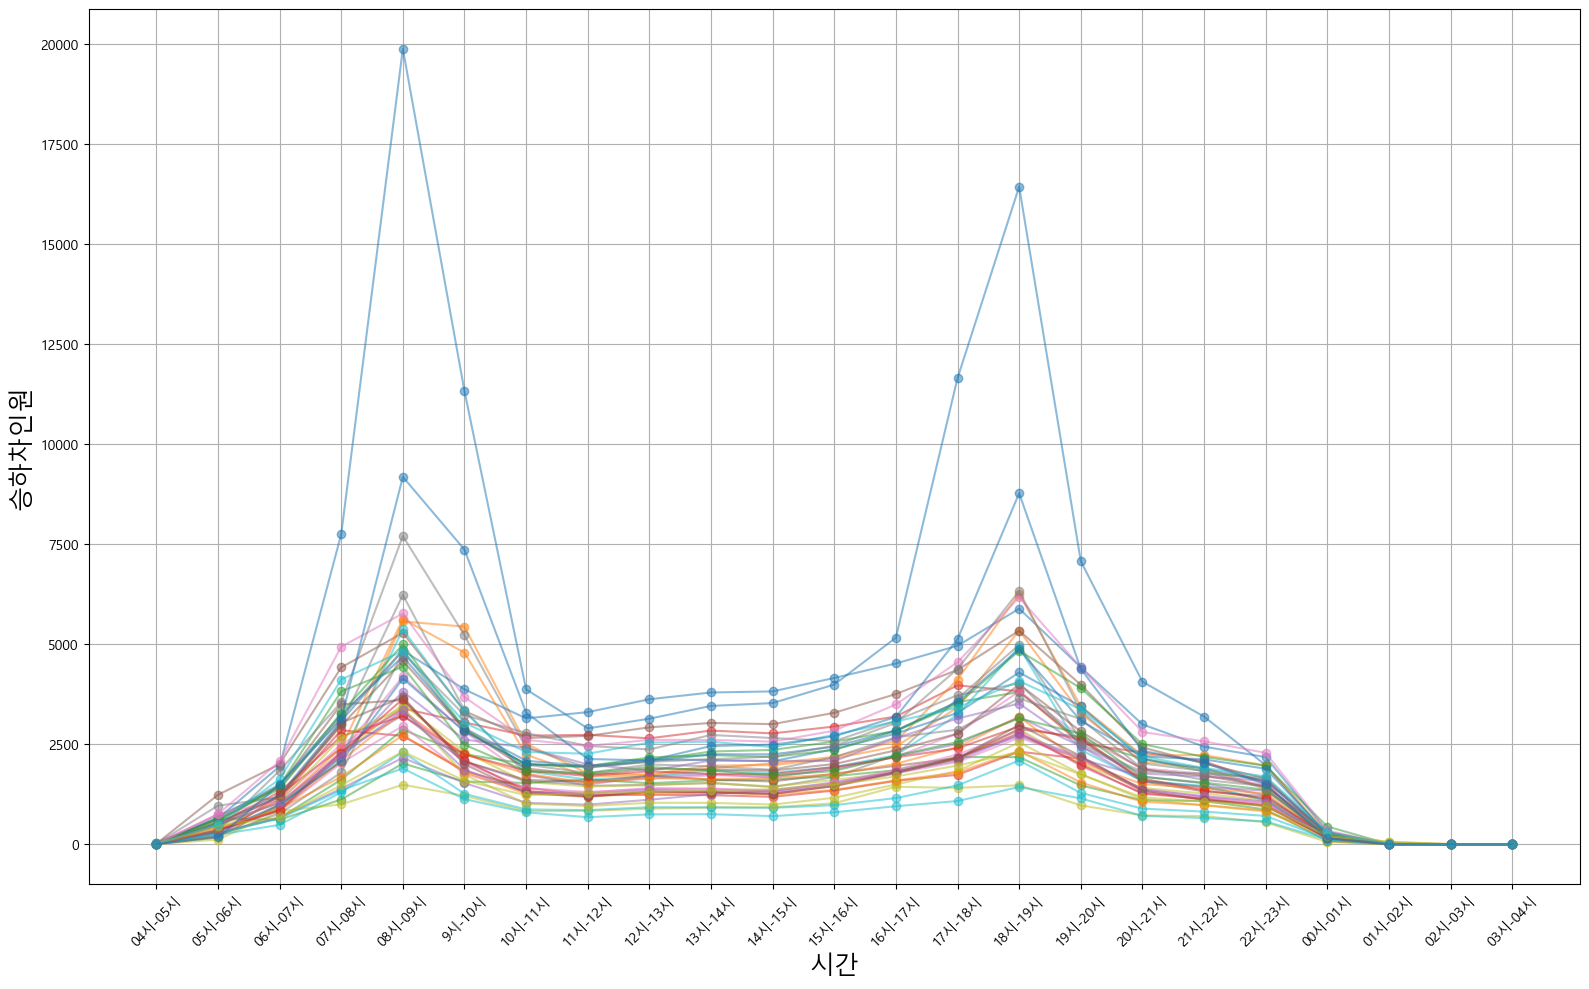

In [16]:
# 전체 역 시간대별 환승인원 시각화

# 각 시간대별 평균 계산
time_slots = personnel_time.columns[1:] 
average_passengers = personnel_time[time_slots].mean()

# 평균이 가장 높은 시간대 찾기
max_time_slot = average_passengers.idxmax()
max_average_value = average_passengers.max()

# 결과 출력
print(f"평균적으로 가장 많은 환승 인원이 발생하는 시간대: {max_time_slot} (평균 환승 인원: {max_average_value})")

# 그래프
plt.figure(figsize=(16, 10))

for _, row in personnel_time.iterrows():
    station_name = row['역명']
    plt.plot(time_slots, row[1:], marker='o', linestyle='-', alpha=0.5, label=station_name)

plt.xticks(rotation=45)
plt.xlabel("시간", fontsize=18)
plt.ylabel("승하차인원", fontsize=18)
# plt.title("시간대별 환승인원")
plt.grid(True)
# plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1), ncol=1)
plt.tight_layout()

# 수직선 추가
# plt.axvline(x=max_time_slot, color='r', linestyle='--', linewidth=2.5, label=f'Peak Time: {max_time_slot}')

plt.show()

평균적으로 가장 혼잡이 많은 시간대: 17시30분 (평균 혼잡도: 44.49105691073171)


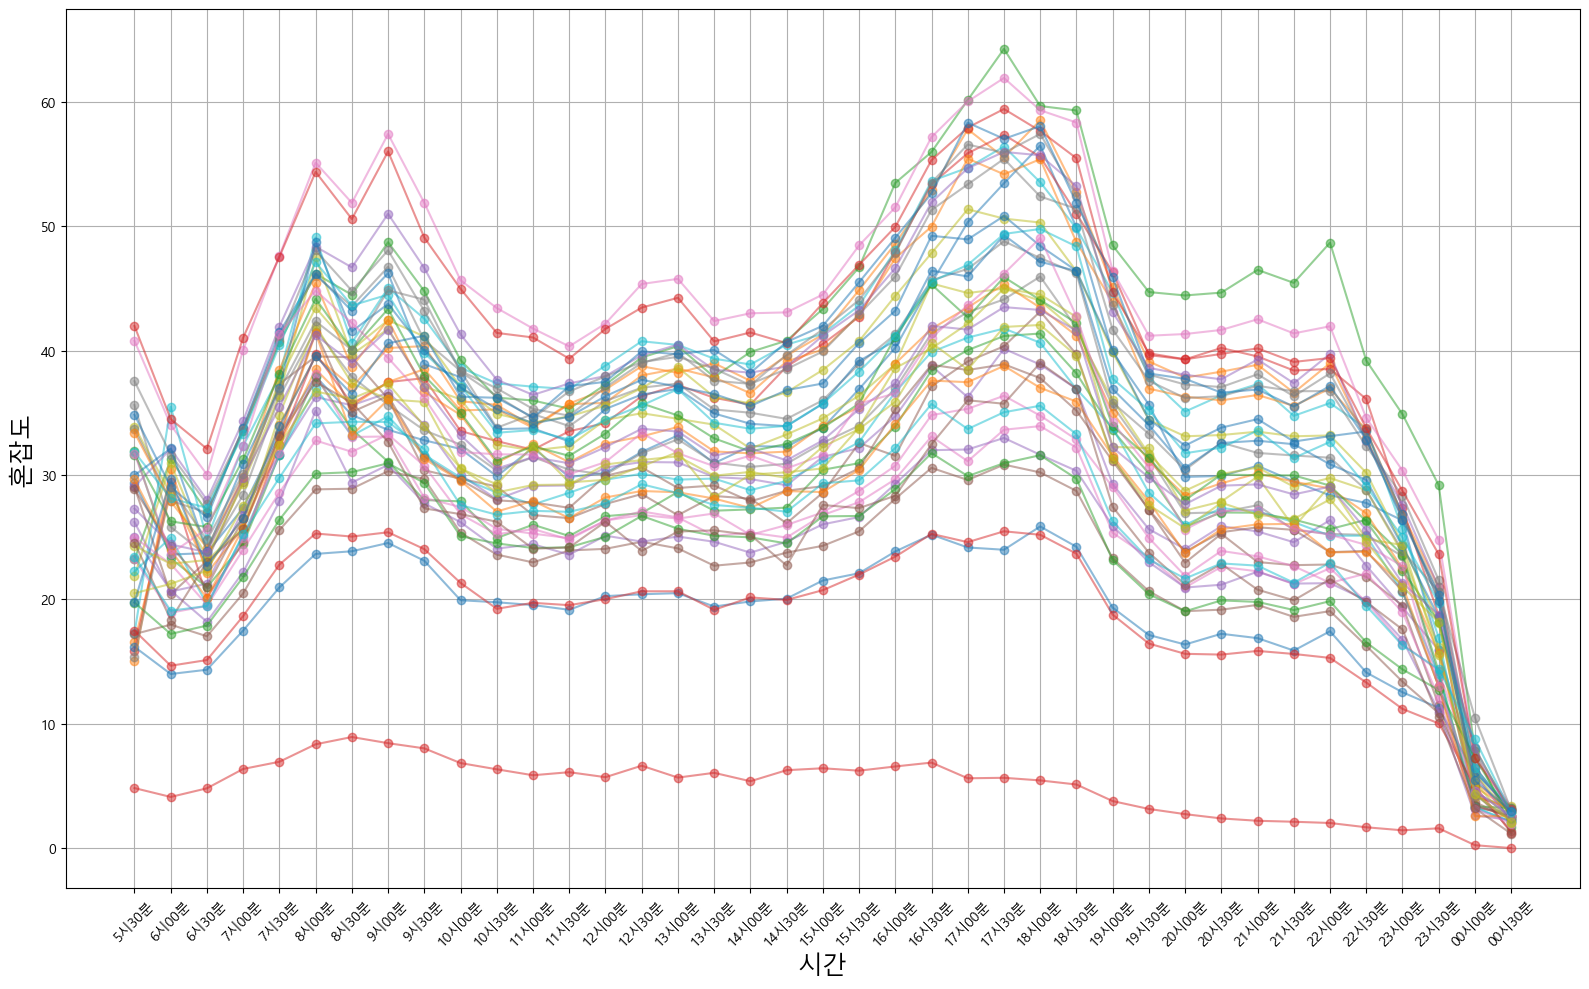

In [17]:
# 전체 역 시간대별 환승인원 시각화

# 각 시간대별 평균 계산
time_slots = crowded.columns[1:] 
average_passengers = crowded[time_slots].mean()

# 평균이 가장 높은 시간대 찾기
max_time_slot = average_passengers.idxmax()
max_average_value = average_passengers.max()

# 결과 출력
print(f"평균적으로 가장 혼잡이 많은 시간대: {max_time_slot} (평균 혼잡도: {max_average_value})")

# 그래프
plt.figure(figsize=(16, 10))

for _, row in crowded.iterrows():
    station_name = row['역명']
    plt.plot(time_slots, row[1:], marker='o', linestyle='-', alpha=0.5, label=station_name)

plt.xticks(rotation=45)
plt.xlabel("시간", fontsize=18)
plt.ylabel("혼잡도", fontsize=18)
# plt.title("시간대별 혼잡도")
plt.grid(True)
# plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1), ncol=1)
plt.tight_layout()

# 수직선 추가
# plt.axvline(x=max_time_slot, color='r', linestyle='--', linewidth=2.5, label=f'Peak Time: {max_time_slot}')


plt.show()

9호선 제외 경의중앙선과 경춘선, 수인분당선, 수도권 전철 1, 4 등은 급행열차를 출퇴근 시간에만 운행하는 경우가 대부분임.

실제로 7호선 또한 출퇴근 시간인 승하차인원과 혼잡도가 가장 높음

따라서 출퇴근시간대 환승인원(07-08시, 08-09시, 09-10시, 17-18시, 18-19시, 19-20시의 평균값)을 종속변수로 선정

----

In [18]:
# model_df 
model_df = independent_variable.copy()
model_df = pd.merge(model_df, station_with_store_count, on='역명', how='left')

# 출퇴근 시간대(07-08시, 08-09시, 09-10시, 17-18시, 18-19시, 19-20시의 평균값) 평균 계산 및 추가
model_df['출퇴근승하차'] = personnel_time[['07시-08시','08시-09시','9시-10시','17시-18시','18시-19시','19시-20시']].mean(axis=1).round().astype(int)

In [19]:
model_df.head(3)

,역명,에스컬레이터 설치 수,버스 정류장 수,경찰서 수,도서관 수,소방서 수,사회복지시설 수,학교 수,구청 수,은행 수,...,아파트(호),연립주택(호),다세대주택(호),비주거용 건물 내 주택(호),주택 이외의 거처 계(호),물품 보관함 수,음식점,편의점,카페,출퇴근승하차
0,가산디지털단지,14,34,2,2,0,0,0,1,6,...,86368,7631,31973,808,17245,26,248,57,144,12355
1,강남구청,7,12,3,3,0,1,0,2,43,...,138025,5645,33229,1548,15217,17,163,28,73,4183
2,건대입구,11,8,5,4,0,0,1,3,8,...,35072,4173,39797,1383,10161,105,244,47,126,2778


In [20]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   역명               41 non-null     object
 1   에스컬레이터 설치 수      41 non-null     int32 
 2   버스 정류장 수         41 non-null     int32 
 3   경찰서 수            41 non-null     int32 
 4   도서관 수            41 non-null     int32 
 5   소방서 수            41 non-null     int32 
 6   사회복지시설 수         41 non-null     int32 
 7   학교 수             41 non-null     int32 
 8   구청 수             41 non-null     int32 
 9   은행 수             41 non-null     int32 
 10  병원 수             41 non-null     int32 
 11  일반적 주거 건물의 수     41 non-null     int32 
 12  아파트 수            41 non-null     int32 
 13  사고발생건수           41 non-null     int32 
 14  총인구(명)           41 non-null     int32 
 15  주택 계(호)          41 non-null     int32 
 16  단독주택(호)          41 non-null     int32 
 17  아파트(호)           41 non-null     int3

In [21]:
model_df.columns

Index(['역명', '에스컬레이터 설치 수', '버스 정류장 수', '경찰서 수', '도서관 수', '소방서 수', '사회복지시설 수',
       '학교 수', '구청 수', '은행 수', '병원 수', '일반적 주거 건물의 수', '아파트 수', '사고발생건수',
       '총인구(명)', '주택 계(호)', '단독주택(호)', '아파트(호)', '연립주택(호)', '다세대주택(호)',
       '비주거용 건물 내 주택(호)', '주택 이외의 거처 계(호)', '물품 보관함 수', '음식점', '편의점', '카페',
       '출퇴근승하차'],
      dtype='object')

| 교통 수단    | 지하철 시설        | 인구    | 주거지                 | 교육 시설 | 공공 기관      | 사회복지시설       | 사고 및 안전 |
|--------------|--------------------|---------|------------------------|------------|----------------|--------------------|--------------|
| 버스 정류장  | 에스컬레이터           | 총인구  | 주택 계                | 학교       | 경찰서         | 사회복지시설       | 사고발생건수 |
|              | 물품 보관함          |         | 단독주택               |            | 도서관         | 병원               |              |
|              |                     |         | 아파트                 |            | 소방서         |                    |              |
|              |                     |         | 연립주택               |            | 구청           |                    |              |
|              |                     |         | 다세대주택             |            |                |                    |              |
|              |                     |         | 비주거용 건물 내 주택  |            |                |                    |              |
|              |                     |         | 주택 이외의 거처 계    |            |                |                    |              |
|              |                     |         | 일반적 주거 건물   |            |                |                    |              |
|              |                     |         | 아파트(호)               |            |                |                    |              |

음식점 편의점 카페 추가


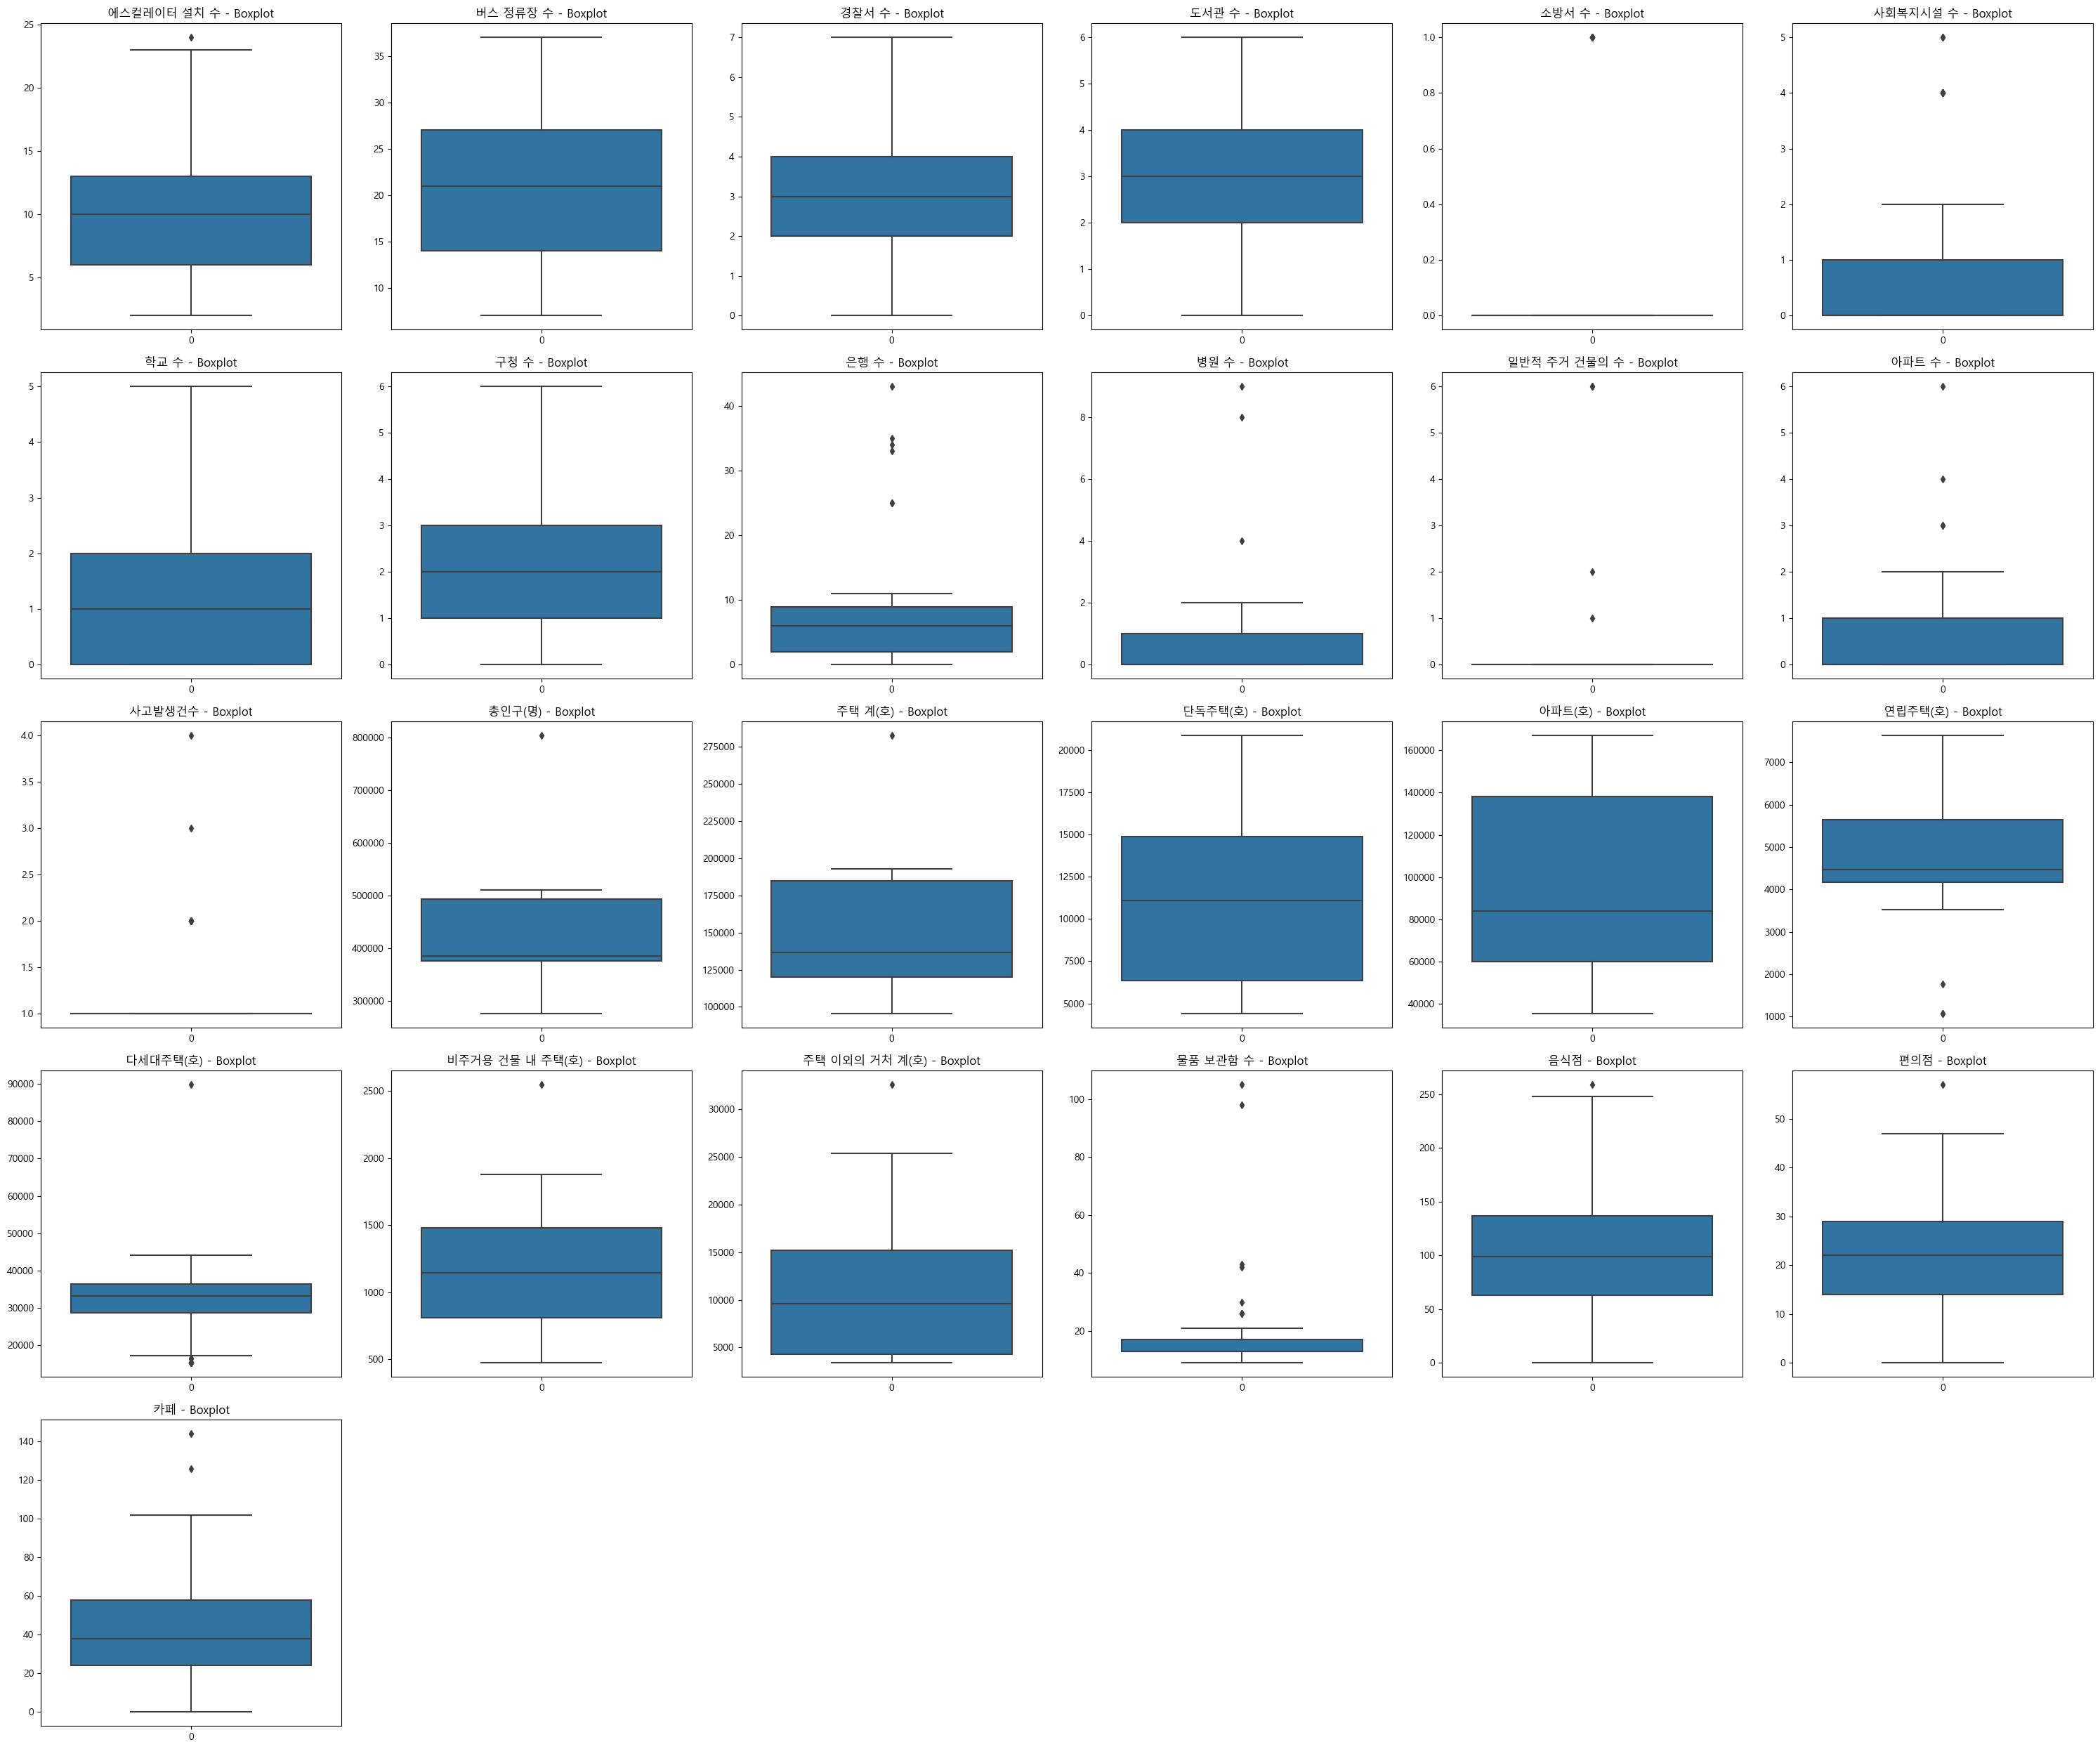

In [22]:
# 변수별 이상치 확인 
columns_to_plot = [col for col in model_df.columns if col not in ['출퇴근승하차', '역명']]
num_columns = 6 

# 서브플롯을 위한 행과 열의 개수 계산
num_rows = len(columns_to_plot) // num_columns + (len(columns_to_plot) % num_columns > 0)

# 서브플롯 생성
fig, axes = plt.subplots(num_rows, num_columns, figsize=(30, 5 * num_rows))

# 각 변수에 대해 박스플롯 그리기
for i, column in enumerate(columns_to_plot):
    row = i // num_columns
    col = i % num_columns
    sns.boxplot(data=model_df[column], ax=axes[row, col])
    axes[row, col].set_title(f'{column} - Boxplot')

# 빈 플롯 제거
for j in range(i + 1, num_rows * num_columns):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()

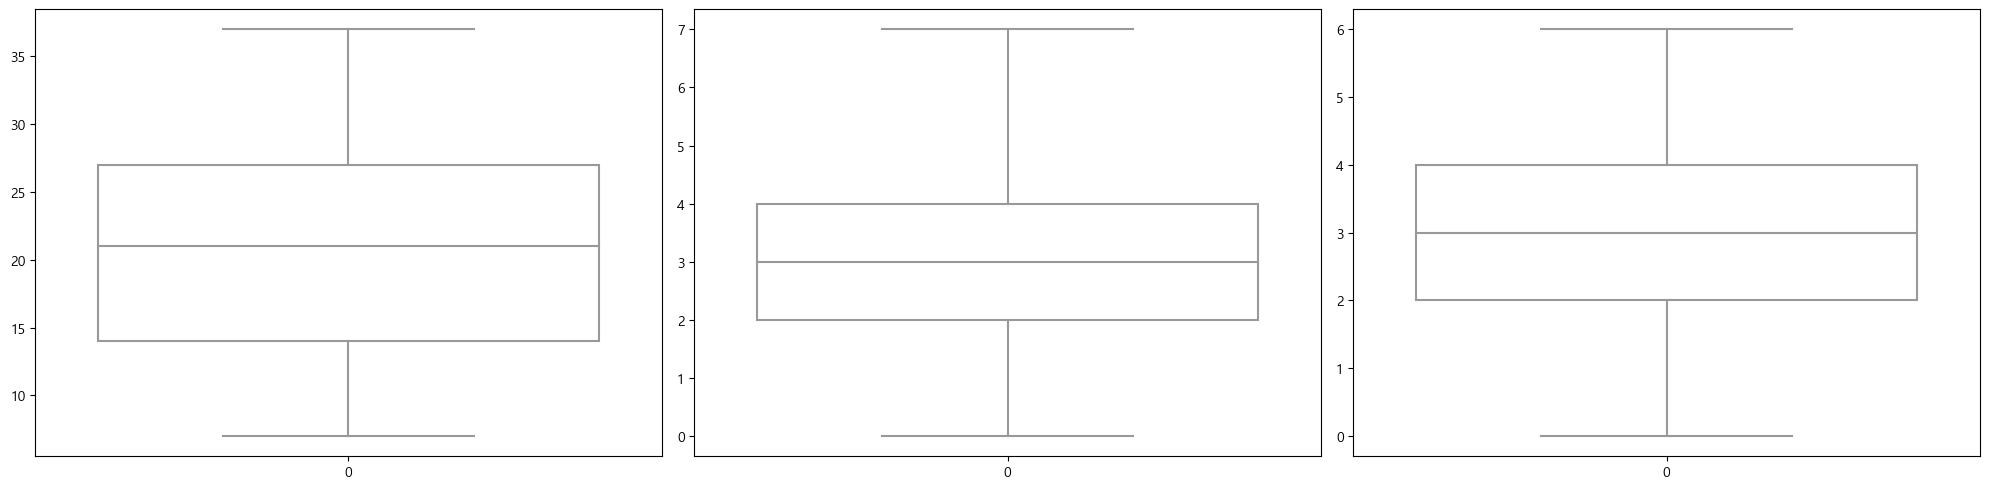

In [23]:
# 변수 선택
columns_to_plot = ['버스 정류장 수', '경찰서 수', '도서관 수']

# 서브플롯 생성 (한 줄에 3개의 플롯)
fig, axes = plt.subplots(1, len(columns_to_plot), figsize=(20, 5))

# 카키색 설정
boxprops = dict(color='WHITE')  # 카키색 설정

# 각 변수에 대해 박스플롯 그리기
for i, column in enumerate(columns_to_plot):
    sns.boxplot(data=model_df[column], ax=axes[i], color='WHITE')
    # axes[i].set_title(f'{column}')

plt.tight_layout()
plt.show()

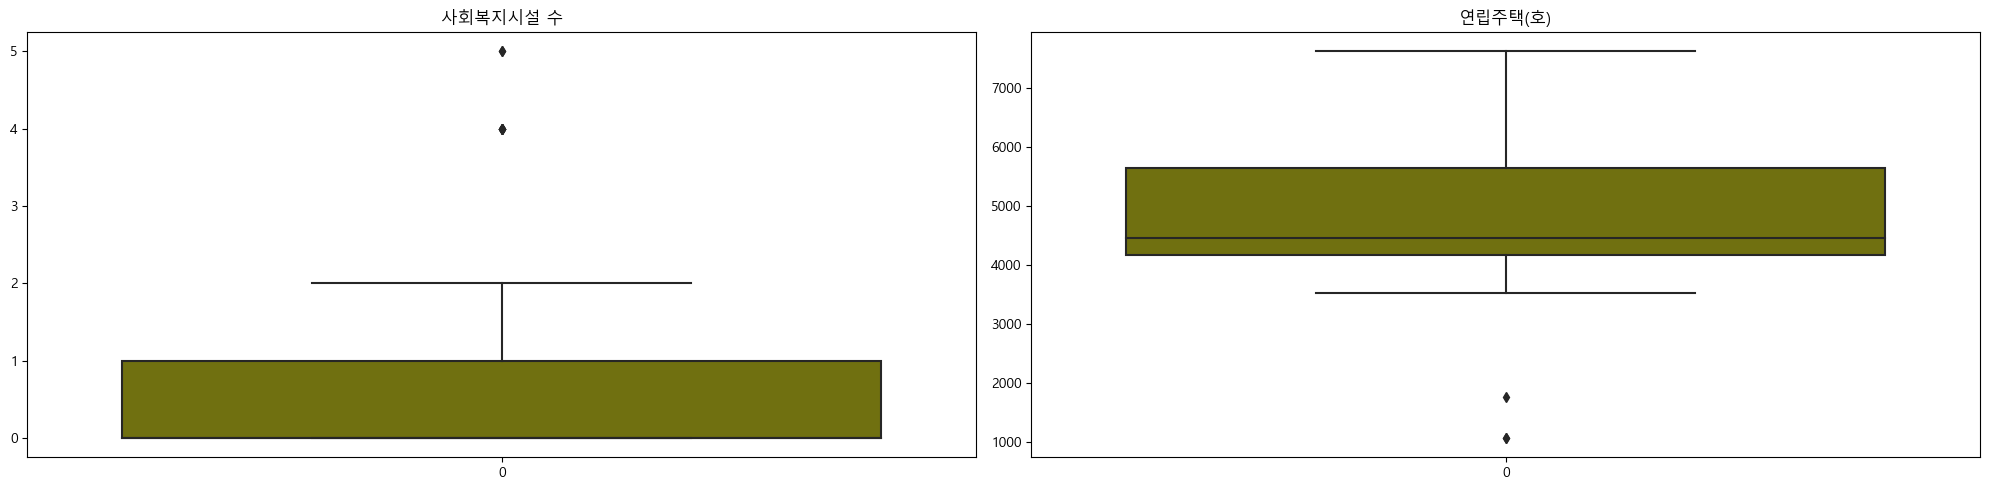

In [24]:
# 변수 선택
columns_to_plot = ['사회복지시설 수' , '연립주택(호)']

# 서브플롯 생성 (한 줄에 3개의 플롯)
fig, axes = plt.subplots(1, len(columns_to_plot), figsize=(20, 5))

# 카키색 설정
boxprops = dict(color='olive')  # 카키색 설정

# 각 변수에 대해 박스플롯 그리기
for i, column in enumerate(columns_to_plot):
    sns.boxplot(data=model_df[column], ax=axes[i], color='olive')
    axes[i].set_title(f'{column}')

plt.tight_layout()
plt.show()

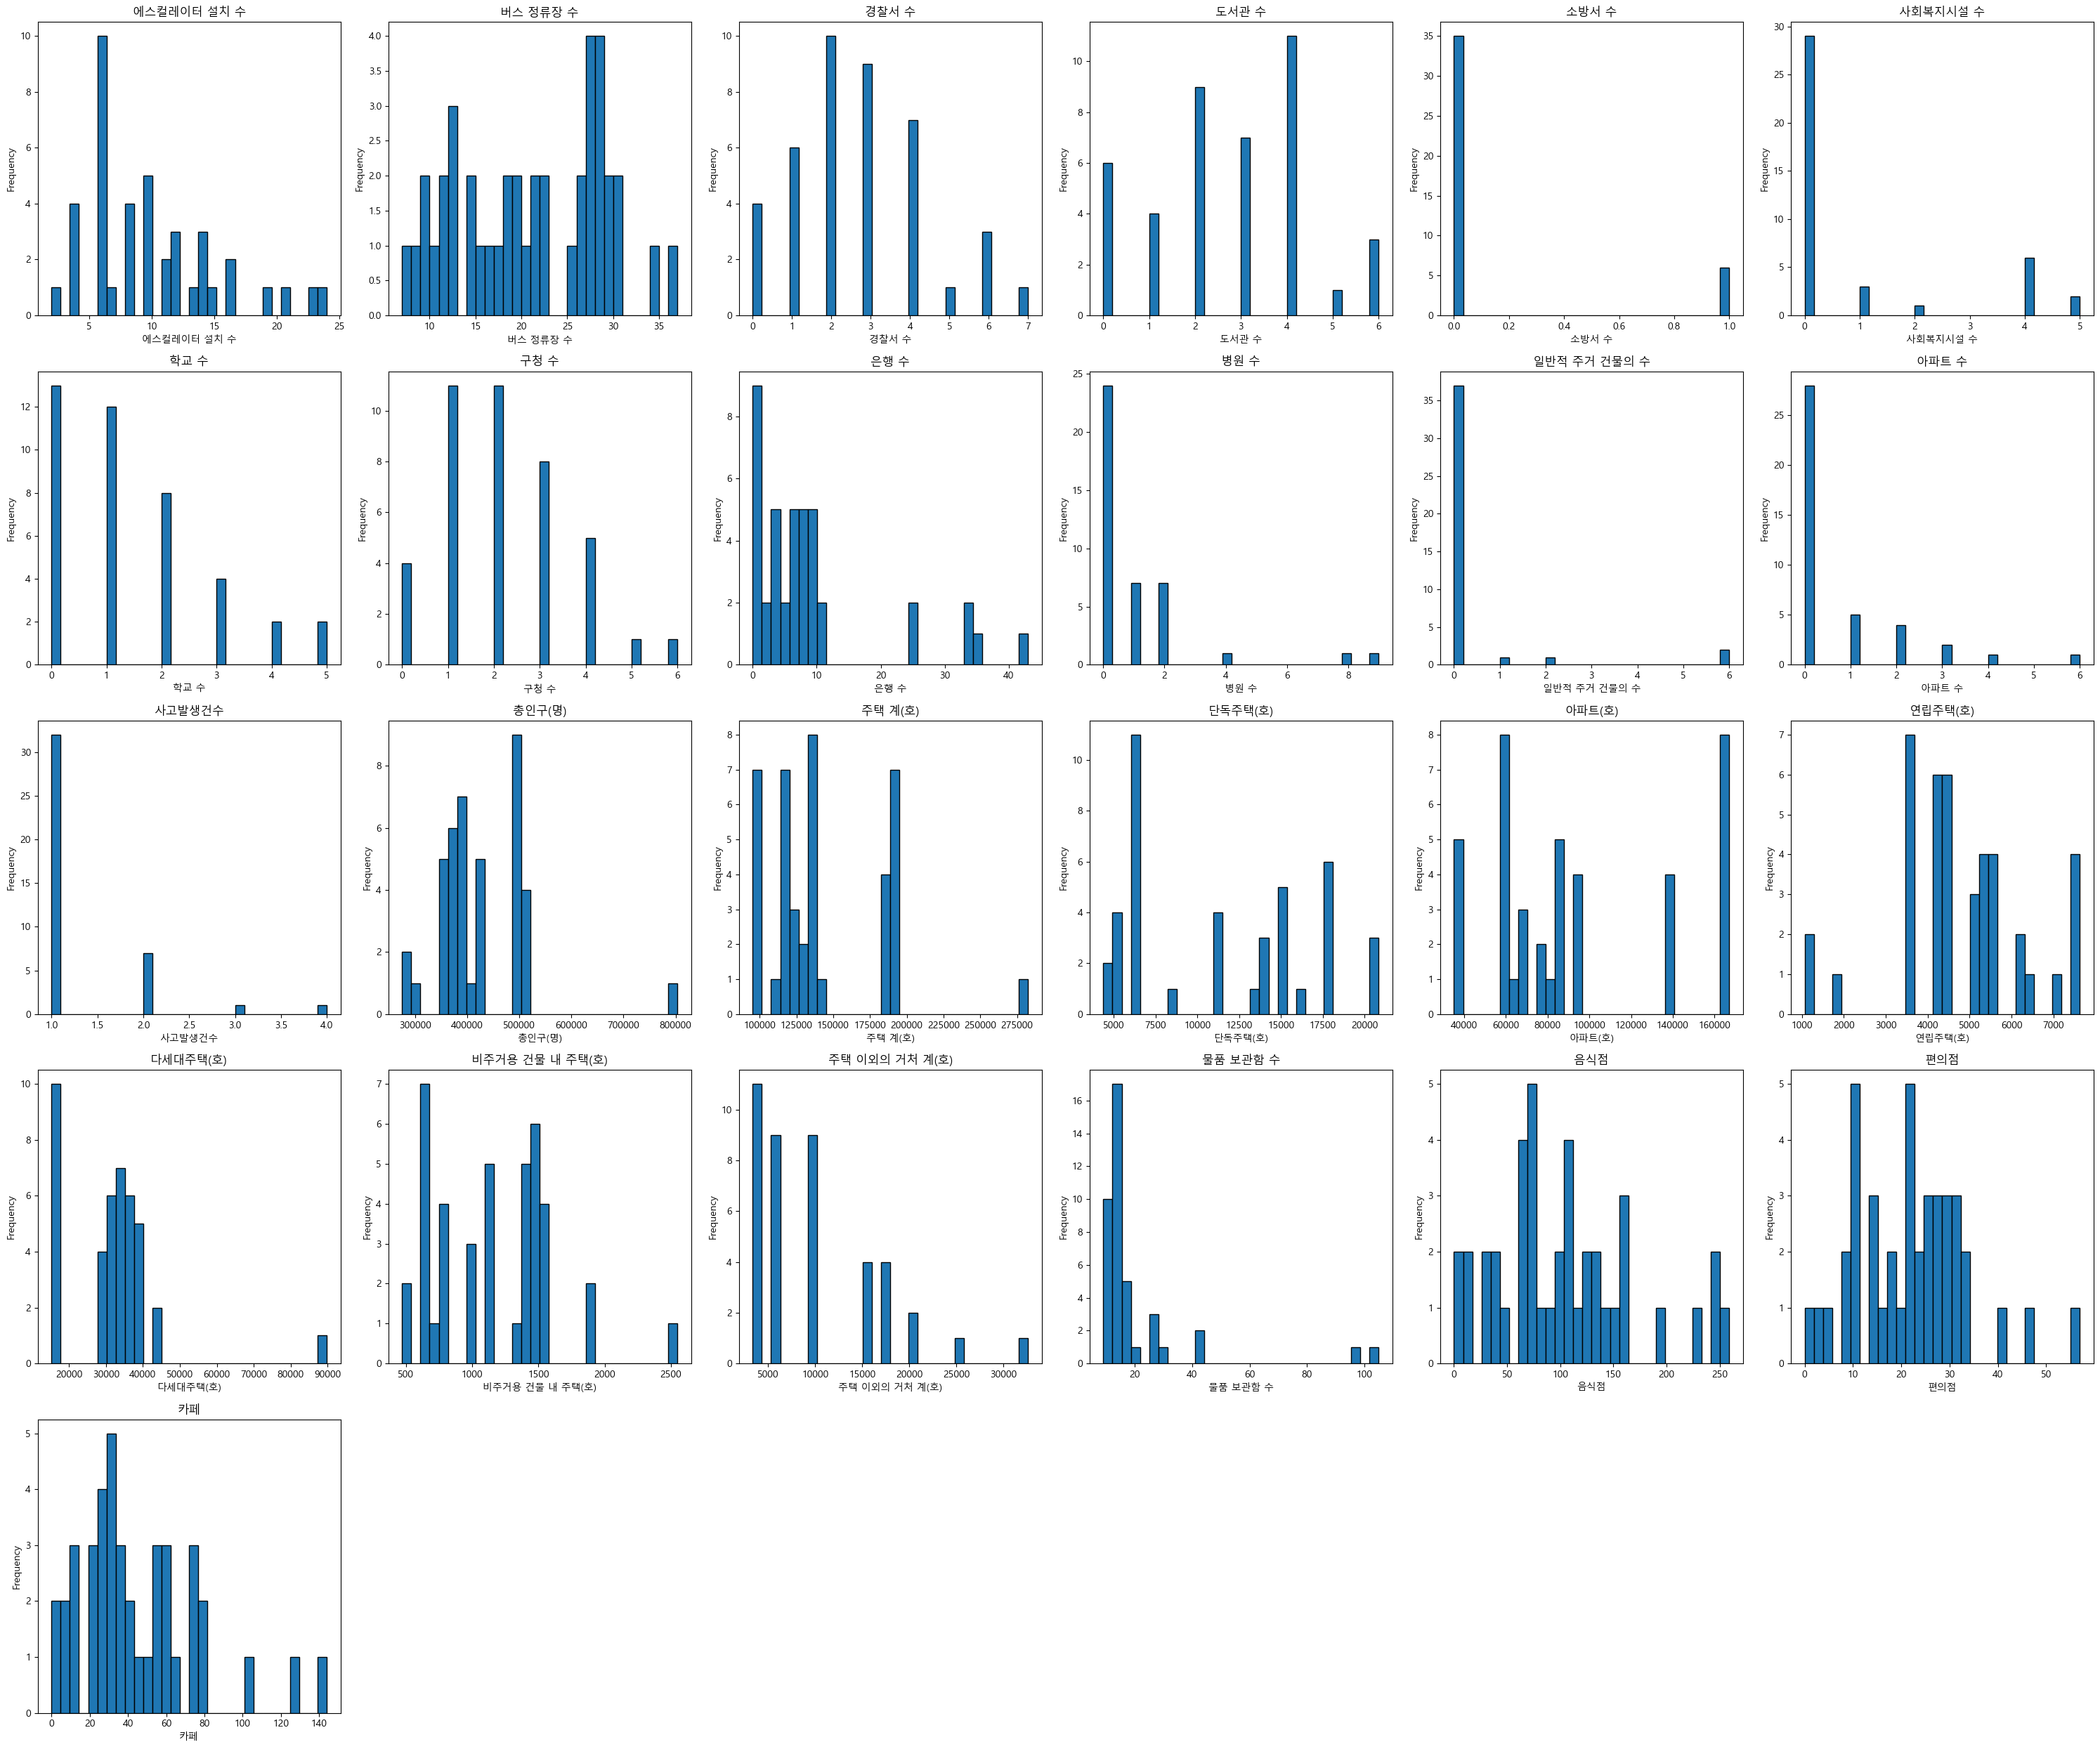

In [25]:
# '출퇴근승하차'와 '역명'을 제외한 모든 칼럼을 선택
columns_to_plot = [col for col in model_df.columns if col not in ['출퇴근승하차', '역명']]

num_columns = 6  # 한 행에 6개의 플롯을 배치

# 서브플롯을 위한 행과 열의 개수 계산
num_rows = len(columns_to_plot) // num_columns + (len(columns_to_plot) % num_columns > 0)

# 서브플롯 생성
fig, axes = plt.subplots(num_rows, num_columns, figsize=(30, 5 * num_rows))

# 각 칼럼에 대해 히스토그램 그리기
for i, column in enumerate(columns_to_plot):
    row = i // num_columns
    col = i % num_columns
    axes[row, col].hist(model_df[column], bins=30, edgecolor='black')
    axes[row, col].set_title(f'{column}')
    axes[row, col].set_xlabel(column)
    axes[row, col].set_ylabel('Frequency')

# 빈 플롯 제거 (만약 마지막 행에 플롯이 부족할 경우)
for j in range(i + 1, num_rows * num_columns):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()

-----
스캐일링

In [26]:
# StandardScaler 스케일링
features_to_scale = model_df.columns.difference(['출퇴근승하차', '역명'])

scaler = StandardScaler()

model_scaled_SS_df = model_df.copy()
model_scaled_SS_df[features_to_scale] = scaler.fit_transform(model_df[features_to_scale])

In [27]:
# 정규화할 피처 선택
features_to_scale = model_df.columns.difference(['출퇴근승하차', '역명'])

# MinMaxScaler를 사용하여 정규화
scaler = MinMaxScaler()

model_scaled_MM_df = model_df.copy()
model_scaled_MM_df[features_to_scale] = scaler.fit_transform(model_df[features_to_scale])

In [28]:
# 독립변수들만 선택
independent_vars = model_scaled_SS_df.drop(columns=['출퇴근승하차', '역명'])

# 상관계수 계산
correlation_matrix = independent_vars.corr()

# 절대값 0.4 이상인 상관관계 찾기
high_correlation_pairs = []

for col1 in correlation_matrix.columns:
    for col2 in correlation_matrix.columns:
        if col1 != col2:
            correlation_value = correlation_matrix.loc[col1, col2]
            if abs(correlation_value) >= 0.7:
                high_correlation_pairs.append((col1, col2, correlation_value))

# 결과 출력
print("Variables with correlation coefficient |r| >= 0.7:")
for pair in high_correlation_pairs:
    print(f"{pair[0]} and {pair[1]}: correlation = {pair[2]:.2f}")

Variables with correlation coefficient |r| >= 0.7:
총인구(명) and 주택 계(호): correlation = 0.92
총인구(명) and 아파트(호): correlation = 0.71
주택 계(호) and 총인구(명): correlation = 0.92
주택 계(호) and 아파트(호): correlation = 0.92
아파트(호) and 총인구(명): correlation = 0.71
아파트(호) and 주택 계(호): correlation = 0.92
다세대주택(호) and 비주거용 건물 내 주택(호): correlation = 0.85
비주거용 건물 내 주택(호) and 다세대주택(호): correlation = 0.85
음식점 and 편의점: correlation = 0.90
음식점 and 카페: correlation = 0.92
편의점 and 음식점: correlation = 0.90
편의점 and 카페: correlation = 0.90
카페 and 음식점: correlation = 0.92
카페 and 편의점: correlation = 0.90


C:\Users\Sun\anaconda\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()
C:\Users\Sun\anaconda\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


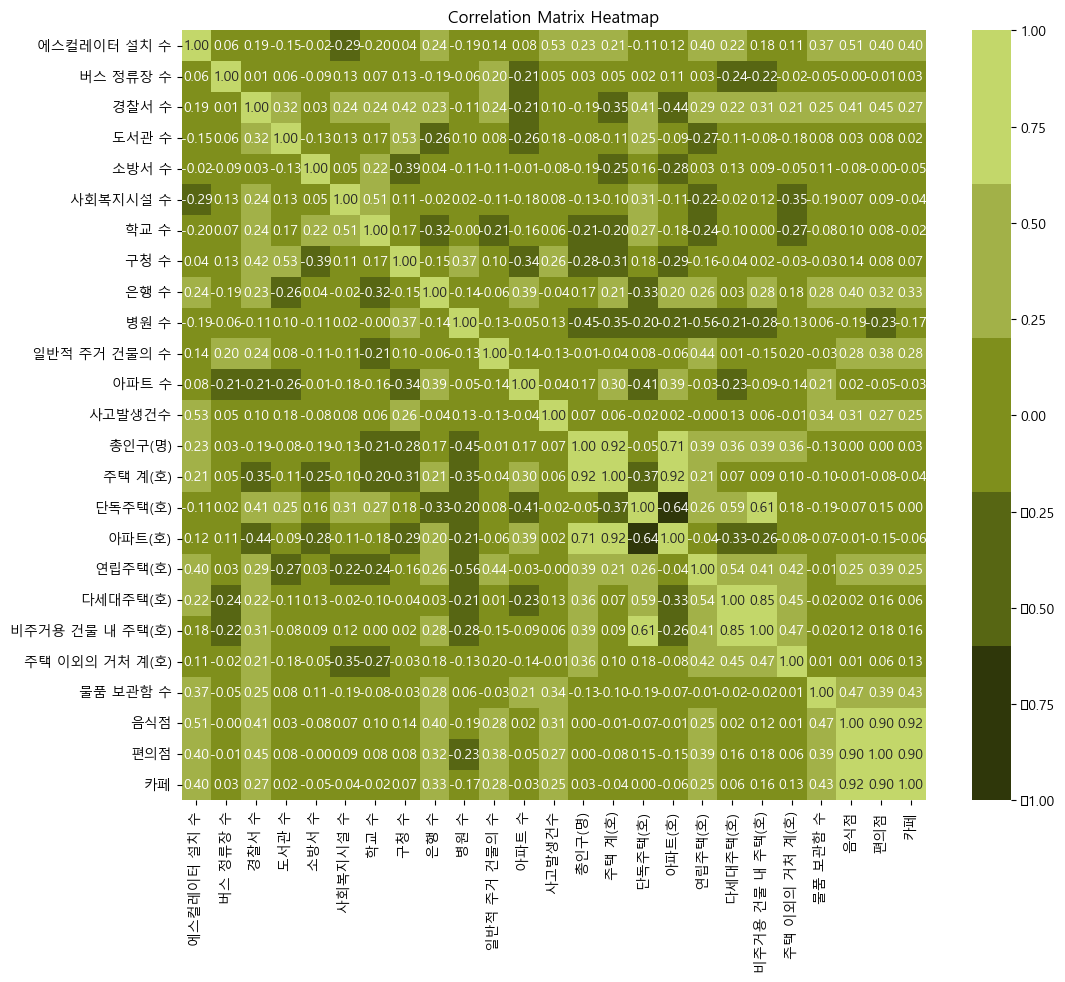

In [29]:
# 상관계수 히트맵 시각화
plt.figure(figsize=(12, 10))

# #576613과 명암 차이를 크게 준 색상 팔레트 정의
cmap = sns.color_palette(["#2F370A", "#576613", "#7F8F1C", "#A2B148", "#C3D76A"])

sns.heatmap(correlation_matrix, annot=True, cmap=cmap, vmin=-1, vmax=1, fmt=".2f")
plt.title("Correlation Matrix Heatmap")
plt.show()

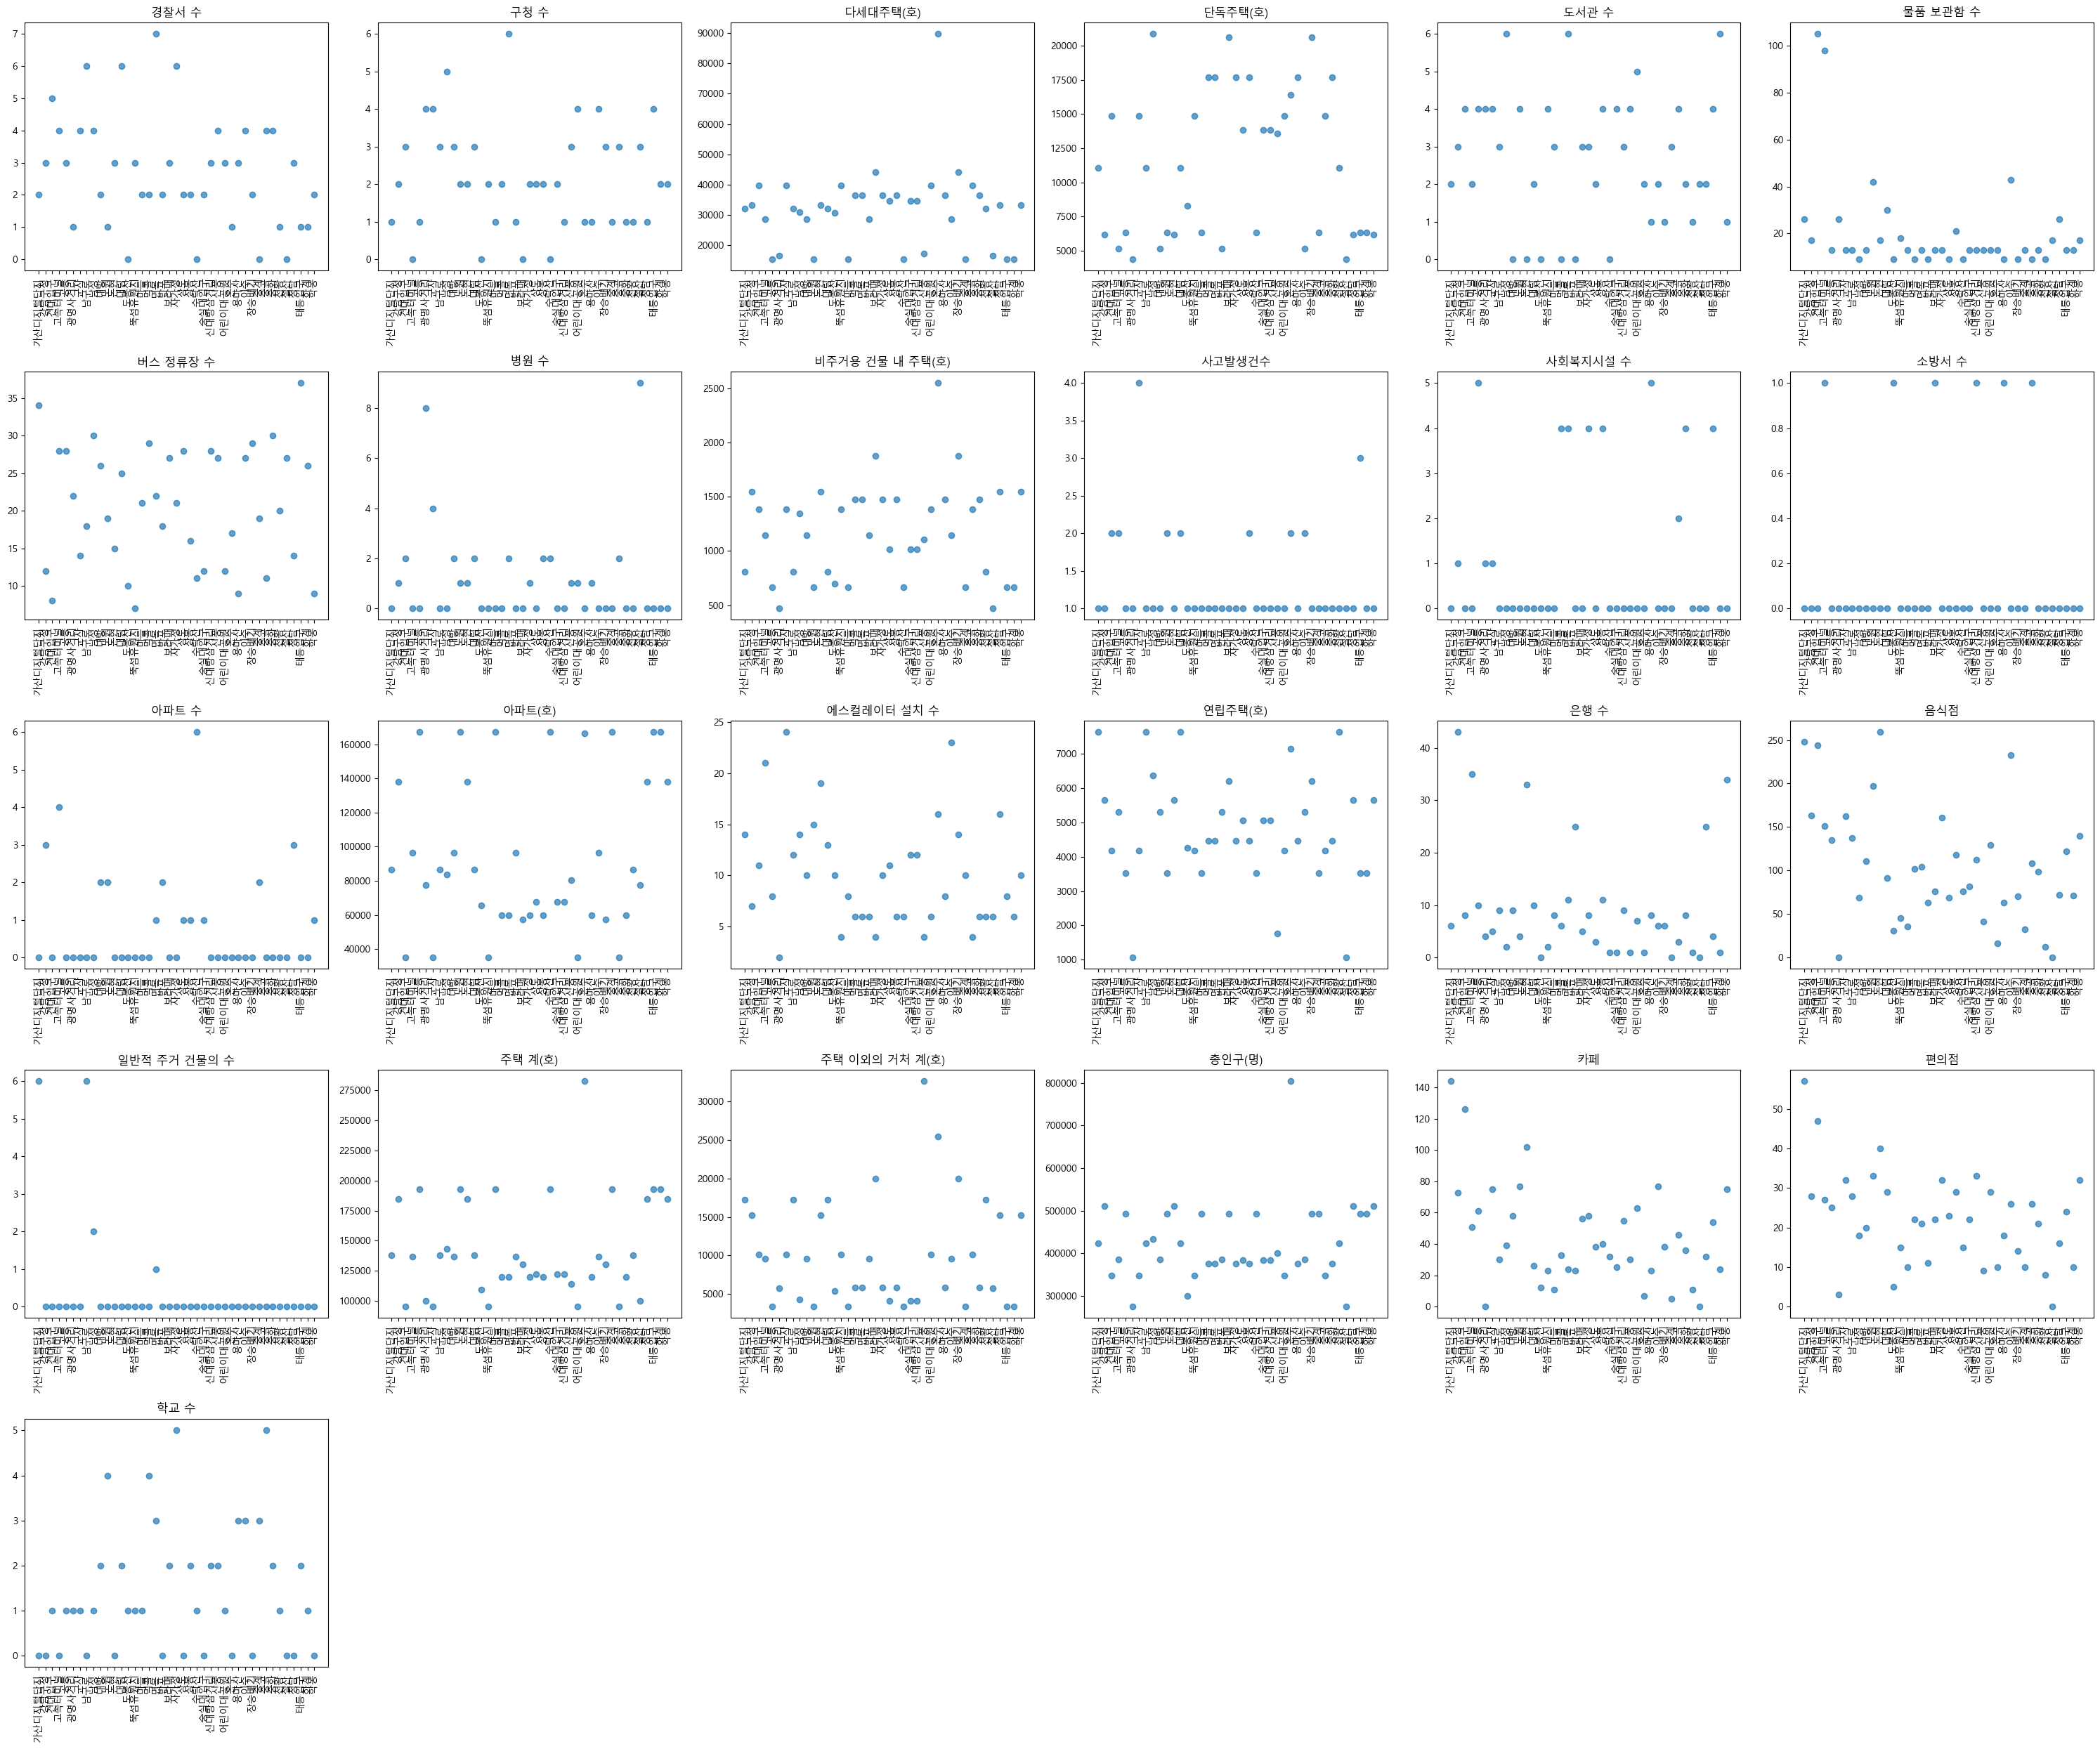

In [30]:
# '출퇴근승하차'와 '역명'을 제외한 모든 칼럼을 시각화 대상으로 선택
columns_to_plot = model_scaled_SS_df.columns.difference(['출퇴근승하차', '역명'])

num_columns = 6  # 한 행에 6개의 플롯을 배치

# 서브플롯을 위한 행과 열의 개수 계산
num_rows = len(columns_to_plot) // num_columns + (len(columns_to_plot) % num_columns > 0)

# 서브플롯 생성
fig, axes = plt.subplots(num_rows, num_columns, figsize=(30, 5 * num_rows))

# 각 변수에 대해 점을 찍는 플롯 그리기
for i, column in enumerate(columns_to_plot):
    row = i // num_columns
    col = i % num_columns
    axes[row, col].scatter(model_df['역명'], model_df[column], alpha=0.7)
    axes[row, col].set_title(f'{column}')
    axes[row, col].tick_params(axis='x', rotation=90)  # x축 라벨을 90도 회전

# 빈 플롯 제거 (만약 마지막 행에 플롯이 부족할 경우)
for j in range(i + 1, num_rows * num_columns):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()

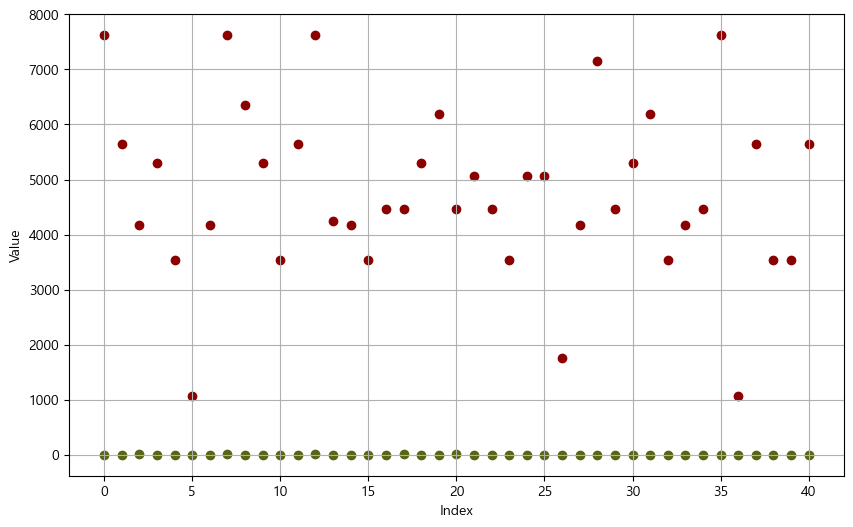

In [31]:
# 산포도 그래프 그리기
plt.figure(figsize=(10, 6))

# 총인구(명) 산포도
plt.scatter(model_df.index, model_df['경찰서 수'], color='#576613', label='경찰서 수')  # 카키색 지정

# 출퇴근승하차 산포도
plt.scatter(model_df.index, model_df['연립주택(호)'], color='#8B0000', label='연립주택(호)')  # 진한 빨간색 지정

# 그래프 레이블 및 설정
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)

plt.show()

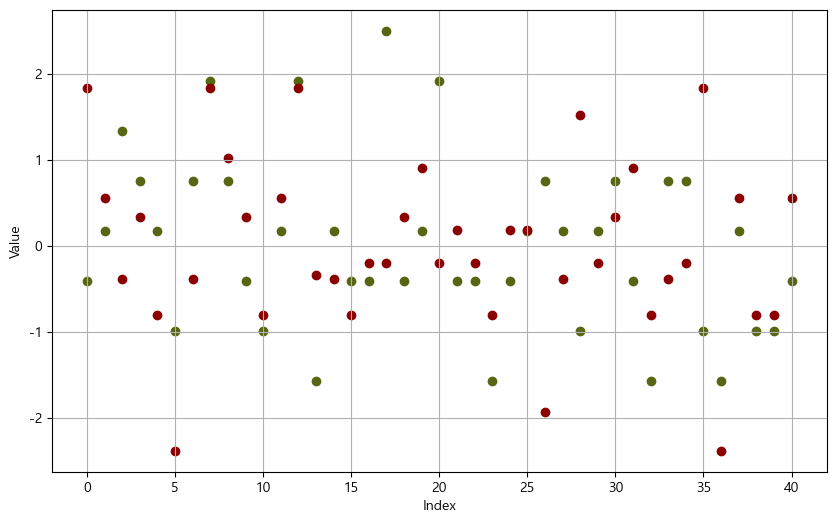

In [32]:
import matplotlib as mpl

# 유니코드 마이너스 활성화
mpl.rcParams['axes.unicode_minus'] = False

# 산포도 그래프 그리기
plt.figure(figsize=(10, 6))

# 총인구(명) 산포도
plt.scatter(model_scaled_SS_df.index, model_scaled_SS_df['경찰서 수'], color='#576613', label='경찰서 수')  # 카키색 지정

# 출퇴근승하차 산포도
plt.scatter(model_scaled_SS_df.index, model_scaled_SS_df['연립주택(호)'], color='#8B0000', label='연립주택(호)')  # 진한 빨간색 지정

# 그래프 레이블 및 설정
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)

plt.show()

In [33]:
# 종속변수 '출퇴근승하차'와 '역명'을 제외한 독립변수들 선택
X = model_scaled_SS_df.drop(columns=['출퇴근승하차', '역명'])

# VIF 계산
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# VIF 결과 출력
vif_data

C:\Users\Sun\anaconda\lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,Variable,VIF
0,에스컬레이터 설치 수,4.609825
1,버스 정류장 수,1.687105
2,경찰서 수,4.603647
3,도서관 수,3.492532
4,소방서 수,2.437149
5,사회복지시설 수,4.264208
6,학교 수,4.917750
7,구청 수,3.942375
8,은행 수,13.880617
9,병원 수,2.840394


-----

높은 상관관계를 가진 변수 쌍:
총인구(명) and 주택 계(호): correlation = 0.92
총인구(명) and 아파트(호): correlation = 0.71
주택 계(호) and 총인구(명): correlation = 0.92
주택 계(호) and 아파트(호): correlation = 0.92
아파트(호) and 총인구(명): correlation = 0.71
아파트(호) and 주택 계(호): correlation = 0.92
다세대주택(호) and 비주거용 건물 내 주택(호): correlation = 0.85
비주거용 건물 내 주택(호) and 다세대주택(호): correlation = 0.85
음식점 and 편의점: correlation = 0.93
음식점 and 카페: correlation = 0.93
편의점 and 음식점: correlation = 0.93
편의점 and 카페: correlation = 0.91
카페 and 음식점: correlation = 0.93
카페 and 편의점: correlation = 0.91

-------------------------------------------------------
13  총인구(명)	138.278380
14	주택 계(호)	inf
15	단독주택(호)	inf
16	아파트(호)	inf
17	연립주택(호)	inf
18	다세대주택(호)	inf
19	비주거용 건물 내 주택(호)	inf

위 변수들 다중공선성이 매우 심하므로 제거

22	음식점	23.283985
23	편의점	29.198281
24	카페	26.005010
pca

은행 수	13.880617
적당하다고 판단. 유지

In [34]:
# model_scaled_SS_df를 카피하여 final_df 생성
final_df = model_scaled_SS_df.copy()

# 제거할 칼럼들 리스트
columns_to_drop = ['총인구(명)', '주택 계(호)', '단독주택(호)', '아파트(호)', '연립주택(호)', '다세대주택(호)', '비주거용 건물 내 주택(호)']

# final_df에서 해당 칼럼들 드랍
final_df = final_df.drop(columns=columns_to_drop)

In [35]:
# PCA를 위한 칼럼들 (음식점, 편의점, 카페)
columns_for_pca = ['음식점', '편의점', '카페']

# 해당 칼럼들에 대해 PCA 수행
pca = PCA(n_components=1)
final_df['PCA_상업시설'] = pca.fit_transform(final_df[columns_for_pca])

# 기존 칼럼들 드랍 (음식점, 편의점, 카페)
final_df.drop(columns=columns_for_pca, inplace=True)

# 출퇴근승하차 칼럼 앞에 PCA 칼럼 이동
final_df = final_df[[col for col in final_df.columns if col not in ['PCA_상업시설', '출퇴근승하차']] + ['PCA_상업시설', '출퇴근승하차']]

In [36]:
final_df.head(3)

,역명,에스컬레이터 설치 수,버스 정류장 수,경찰서 수,도서관 수,소방서 수,사회복지시설 수,학교 수,구청 수,은행 수,병원 수,일반적 주거 건물의 수,아파트 수,사고발생건수,주택 이외의 거처 계(호),물품 보관함 수,PCA_상업시설,출퇴근승하차
0,가산디지털단지,0.744130,1.709417,-0.412605,-0.404482,-0.414039,-0.565752,-1.013033,-0.825197,-0.295550,-0.530330,4.266090,-0.539447,-0.461538,1.074852,0.305339,4.858959,12355
1,강남구청,-0.590653,-1.088939,0.170733,0.187795,-0.414039,0.029013,-1.013033,-0.105344,3.234763,-0.012627,-0.277019,1.748554,-0.461538,0.774673,-0.141765,1.353987,4183
2,건대입구,0.172080,-1.597731,1.337409,0.780073,-0.414039,-0.565752,-0.296923,0.614508,-0.104723,0.505076,-0.277019,-0.539447,1.115385,0.026300,4.229921,3.992017,2778


In [37]:
final_df.tail(3)

,역명,에스컬레이터 설치 수,버스 정류장 수,경찰서 수,도서관 수,소방서 수,사회복지시설 수,학교 수,구청 수,은행 수,병원 수,일반적 주거 건물의 수,아파트 수,사고발생건수,주택 이외의 거처 계(호),물품 보관함 수,PCA_상업시설,출퇴근승하차
38,태릉입구,-0.399970,2.091011,-0.995943,0.780073,-0.414039,1.813309,0.419186,1.334360,-0.486378,-0.53033,-0.277019,-0.539447,2.692308,-0.977846,-0.340478,0.443789,1896
39,하계,-0.781336,0.691833,-0.995943,1.964629,-0.414039,-0.565752,-0.296923,-0.105344,-0.772620,-0.53033,-0.277019,-0.539447,-0.461538,-0.977846,-0.340478,-1.256677,3808
40,학동,-0.018603,-1.470533,-0.412605,-0.996760,-0.414039,-0.565752,-1.013033,-0.105344,2.376038,-0.53033,-0.277019,0.223220,-0.461538,0.774673,-0.141765,1.389016,6325


----

In [51]:
# 그냥 돌렸을 때
# 회귀분석
X = model_scaled_SS_df.drop(columns=['출퇴근승하차', '역명'])  
y = model_scaled_SS_df['출퇴근승하차'] 

X = sm.add_constant(X)

# 회귀 모델 적합
model = sm.OLS(y, X)
results = model.fit()

# 결과 출력
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 출퇴근승하차   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     5.891
Date:                Sun, 01 Sep 2024   Prob (F-statistic):           0.000306
Time:                        22:48:30   Log-Likelihood:                -318.20
No. Observations:                  41   AIC:                             686.4
Df Residuals:                      16   BIC:                             729.2
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            3311.9756    141.986     

In [52]:
# 회귀분석
X = final_df.drop(columns=['출퇴근승하차', '역명'])  
y = final_df['출퇴근승하차'] 

X = sm.add_constant(X)

# 회귀 모델 적합
model = sm.OLS(y, X)
results = model.fit()

# 결과 출력
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 출퇴근승하차   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.674
Method:                 Least Squares   F-statistic:                     6.168
Date:                Sun, 01 Sep 2024   Prob (F-statistic):           3.95e-05
Time:                        22:48:33   Log-Likelihood:                -331.62
No. Observations:                  41   AIC:                             697.2
Df Residuals:                      24   BIC:                             726.4
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           3311.9756    160.811     20.

p-value 기준으로 변수들을 선택
- 에스컬레이터 설치 수: p-value = 0.056
- 경찰서 수: p-value = 0.001
- 도서관 수: p-value = 0.018
- 은행 수: p-value = 0.062
- 병원 수: p-value = 0.001
- 일반적 주거 건물의 수: p-value = 0.000
- 사고발생건수: p-value = 0.023
- PCA_상업시설: p-value = 0.004


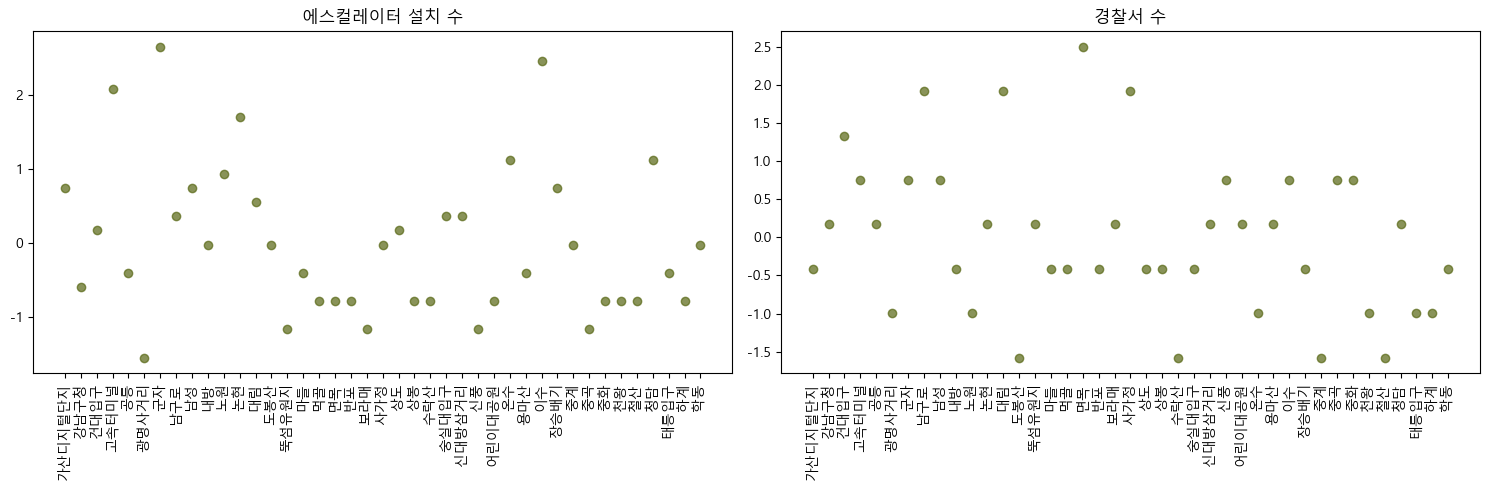

In [114]:
# 시각화할 칼럼들만 선택
columns_to_plot = ['에스컬레이터 설치 수', '경찰서 수']

num_columns = 2  # 한 행에 2개의 플롯을 배치 (선택한 칼럼 수에 맞게 수정)
num_rows = len(columns_to_plot) // num_columns + (len(columns_to_plot) % num_columns > 0)

# 서브플롯 생성
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 5 * num_rows))

# 카키색 설정
kaki_color = '#576613'

# 각 변수에 대해 점을 찍는 플롯 그리기
for i, column in enumerate(columns_to_plot):
    if num_rows == 1:
        ax = axes[i % num_columns]  # 1차원 배열인 경우
    else:
        row = i // num_columns
        col = i % num_columns
        ax = axes[row, col]  # 2차원 배열인 경우
    ax.scatter(model_df['역명'], final_df[column], alpha=0.7, color=kaki_color)
    ax.set_title(f'{column}')
    ax.tick_params(axis='x', rotation=90)  # x축 라벨을 90도 회전

# 빈 플롯 제거 (만약 마지막 행에 플롯이 부족할 경우)
if num_rows > 1:  # 여러 행인 경우에만 실행
    for j in range(i + 1, num_rows * num_columns):
        fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()

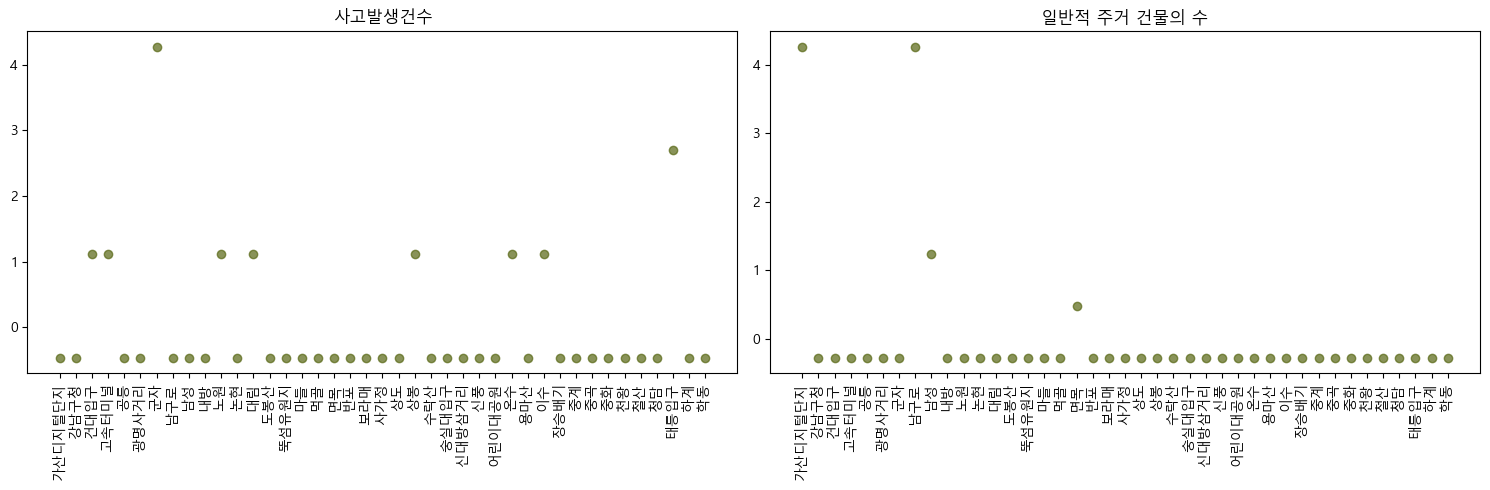

In [115]:
# 시각화할 칼럼들만 선택
columns_to_plot = ['사고발생건수', '일반적 주거 건물의 수']

num_columns = 2  # 한 행에 2개의 플롯을 배치 (선택한 칼럼 수에 맞게 수정)
num_rows = len(columns_to_plot) // num_columns + (len(columns_to_plot) % num_columns > 0)

# 서브플롯 생성
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 5 * num_rows))

# 카키색 설정
kaki_color = '#576613'

# 각 변수에 대해 점을 찍는 플롯 그리기
for i, column in enumerate(columns_to_plot):
    if num_rows == 1:
        ax = axes[i % num_columns]  # 1차원 배열인 경우
    else:
        row = i // num_columns
        col = i % num_columns
        ax = axes[row, col]  # 2차원 배열인 경우
    ax.scatter(model_df['역명'], final_df[column], alpha=0.7, color=kaki_color)
    ax.set_title(f'{column}')
    ax.tick_params(axis='x', rotation=90)  # x축 라벨을 90도 회전

# 빈 플롯 제거 (만약 마지막 행에 플롯이 부족할 경우)
if num_rows > 1:  # 여러 행인 경우에만 실행
    for j in range(i + 1, num_rows * num_columns):
        fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()

In [58]:
selected_columns = ['에스컬레이터 설치 수', '경찰서 수', '도서관 수', '은행 수', '병원 수', '사고발생건수', '일반적 주거 건물의 수']
subset_df = model_df[selected_columns]

In [59]:
subset_df

,에스컬레이터 설치 수,경찰서 수,도서관 수,은행 수,병원 수,사고발생건수,일반적 주거 건물의 수
0,14,2,2,6,0,1,6
1,7,3,3,43,1,1,0
2,11,5,4,8,2,2,0
3,21,4,2,35,0,2,0
4,8,3,4,10,0,1,0
5,2,1,4,4,8,1,0
6,24,4,4,5,4,4,0
7,12,6,3,9,0,1,6
8,14,4,6,2,0,1,2
9,10,2,0,9,2,1,0


-----

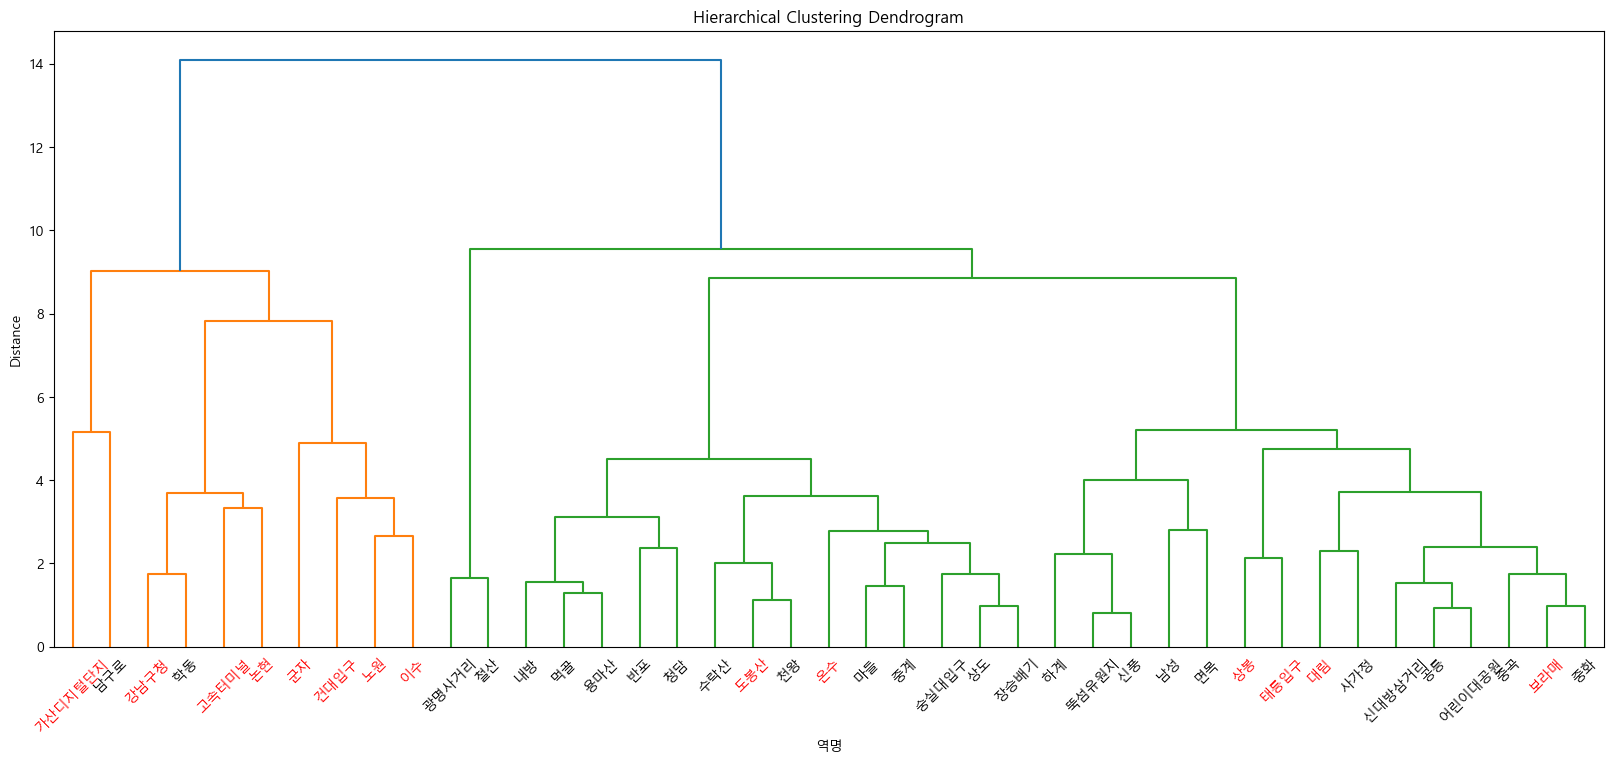

In [61]:
# 주어진 변수만 전부 선택
selected_features = ['에스컬레이터 설치 수', '경찰서 수', '도서관 수', '은행 수', '병원 수', '사고발생건수', 'PCA_상업시설', '일반적 주거 건물의 수']

# 선택한 변수들만 사용하여 데이터프레임 생성
X = final_df[selected_features]

# 계층적 군집화 수행 (유클리드 거리와 워드 연결법 사용)
Z = linkage(X, method='ward', metric='euclidean')

# 강조할 역명 리스트
highlight_stations = ['도봉산', '노원', '태릉입구', '상봉', '군자', '건대입구', '강남구청', 
                      '논현', '고속터미널', '이수', '보라매', '대림', '가산디지털단지', '온수']

# 덴드로그램 시각화
plt.figure(figsize=(20, 8))
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("역명")
plt.ylabel("Distance")

# 덴드로그램 생성
dend = dendrogram(Z, labels=final_df['역명'].tolist(), leaf_rotation=45, leaf_font_size=10)

# 레이블 색상 변경
ax = plt.gca()
x_labels = ax.get_xmajorticklabels()

for label in x_labels:
    if label.get_text() in highlight_stations:
        label.set_color('red')

plt.show()

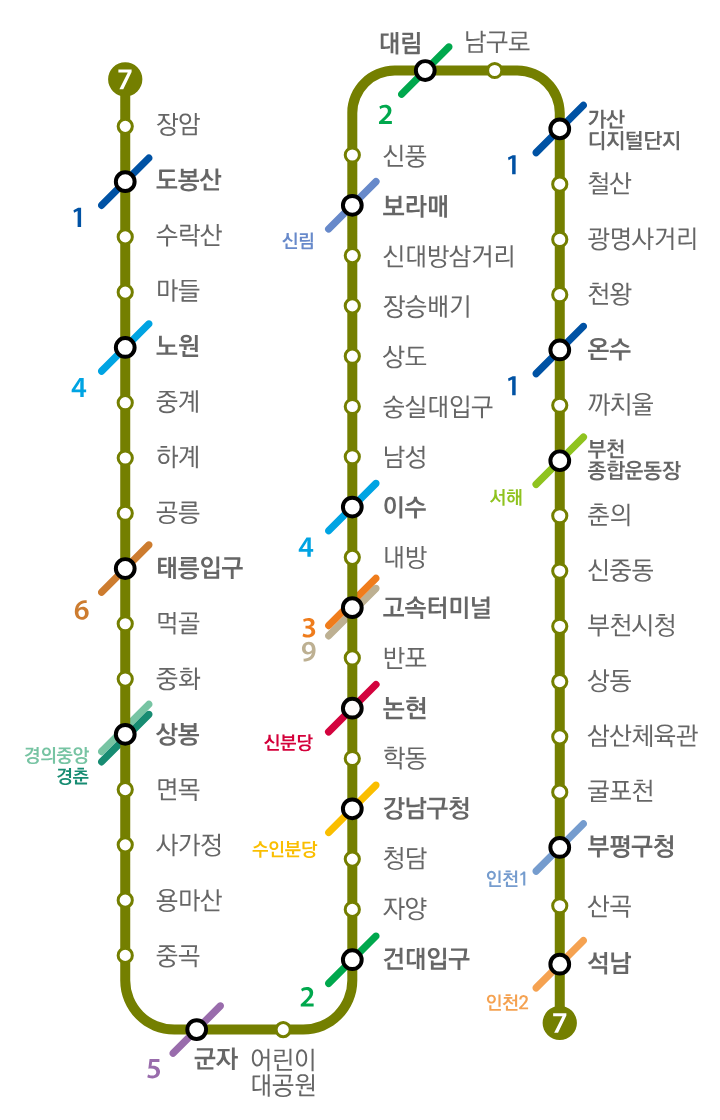

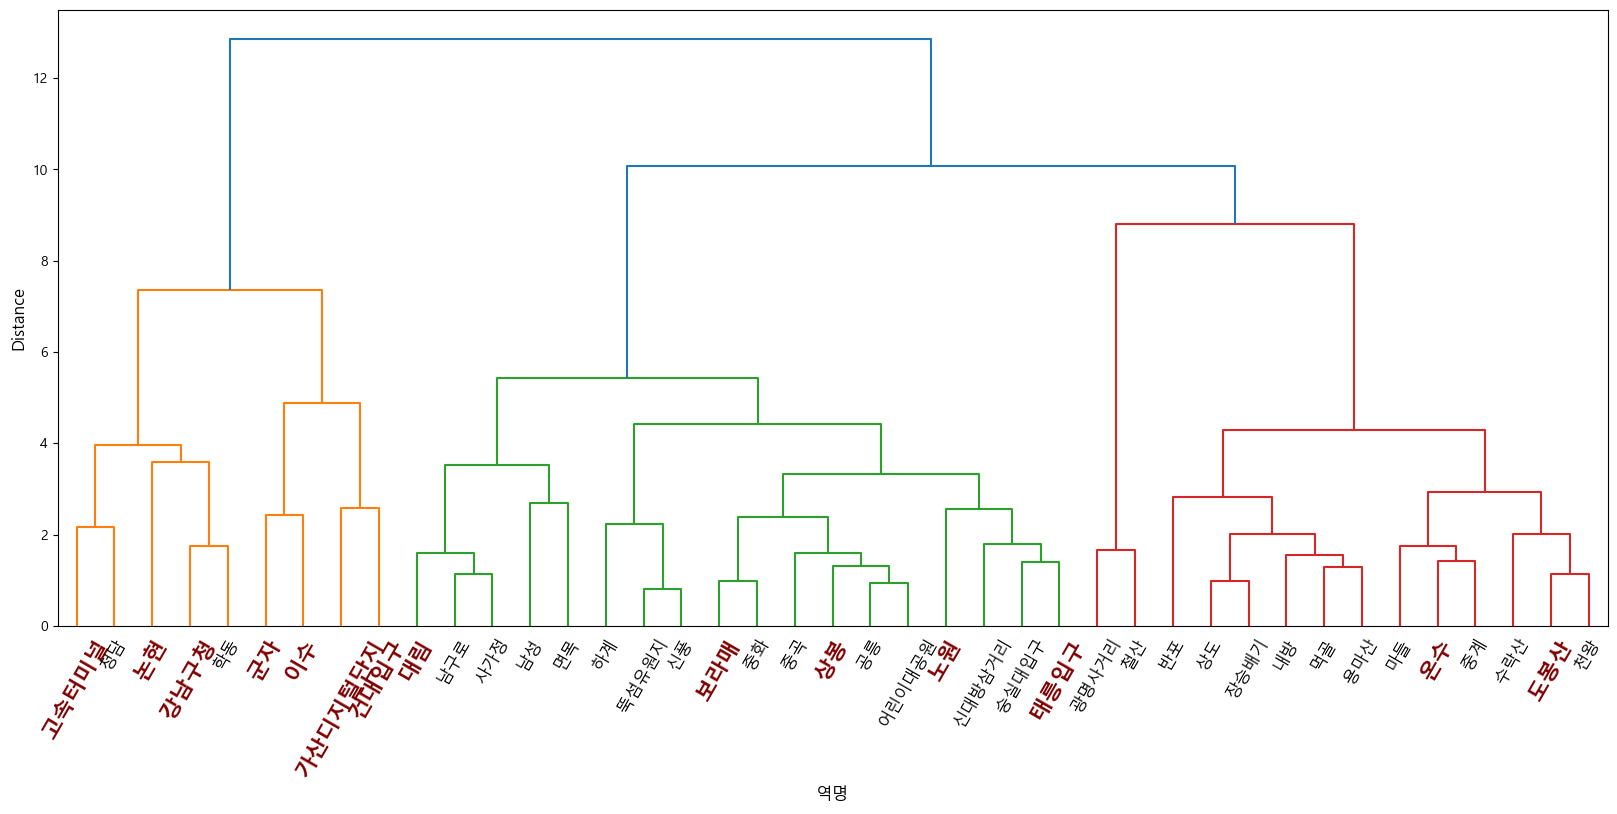

In [50]:
# 주어진 변수 선택
selected_features = ['에스컬레이터 설치 수', '경찰서 수', '도서관 수', '은행 수', '병원 수', 'PCA_상업시설']
X = final_df[selected_features]

# 계층적 군집화 수행 (유클리드 거리와 워드 연결법 사용)
Z = linkage(X, method='ward', metric='euclidean')

# 강조할 역명 리스트
highlight_stations = ['도봉산', '노원', '태릉입구', '상봉', '군자', '건대입구', '강남구청', 
                      '논현', '고속터미널', '이수', '보라매', '대림', '가산디지털단지', '온수']

# 덴드로그램 시각화
plt.figure(figsize=(20, 8))
plt.xlabel("역명", fontsize=12)  # X LABEL 크기와 굵기 설정
plt.ylabel("Distance", fontsize=12)  # Y LABEL도 동일하게 설정 가능

# 덴드로그램 생성
dend = dendrogram(Z, labels=final_df['역명'].tolist(), leaf_rotation=60, leaf_font_size=12)

# 레이블 색상 변경 및 강조
ax = plt.gca()
x_labels = ax.get_xmajorticklabels()

for label in x_labels:
    if label.get_text() in highlight_stations:
        label.set_color('#800000')  # 더 진한 초록색 설정
        label.set_fontweight('bold')  # 강조된 역명을 굵게 설정
        label.set_fontsize(16)  # 글자 크기 키우기
    else:
        label.set_fontweight('normal')  # 다른 역명은 기본 굵기

plt.show()

In [65]:
# 주어진 그룹별 역명 리스트
group1 = ['고속터미널', '장암', '논현', '강남구청', '학동', '군자', '이수', '가산디지털단지', '건대입구']
group2 = ['대림', '남구로', '사가정', '남성', '면목', '하계', '뚝섬유원지', '신풍', '보라매', '중화', '중곡', '상봉', '공릉', 
          '어린이대공원', '노원', '신대방삼거리', '숭실대입구', '태릉입구']
group3 = ['광명사거리', '철산', '반포', '상도', '장승배기', '내방', '먹골', '용마산', '마들', '온수', '중계', 
          '수락산', '도봉산', '천왕']

# 선택한 변수들만 사용하여 데이터프레임 생성
X = final_df[selected_features]

# 각 그룹의 데이터 선택
group1_data = X[final_df['역명'].isin(group1)]
group2_data = X[final_df['역명'].isin(group2)]
group3_data = X[final_df['역명'].isin(group3)]

# 각 그룹의 센트로이드 계산 (평균값)
centroid1 = group1_data.mean(axis=0)
centroid2 = group2_data.mean(axis=0)
centroid3 = group3_data.mean(axis=0)

# 센트로이드 출력
print("Centroid for Group 1:")
print(centroid1)
print("\nCentroid for Group 2:")
print(centroid2)
print("\nCentroid for Group 3:")
print(centroid3)

Centroid for Group 1:
에스컬레이터 설치 수    1.149332
경찰서 수          0.389485
도서관 수         -0.256413
은행 수           1.159511
병원 수          -0.012627
PCA_상업시설       2.405108
dtype: float64

Centroid for Group 2:
에스컬레이터 설치 수   -0.336409
경찰서 수          0.462402
도서관 수          0.747169
은행 수          -0.306152
병원 수          -0.185195
PCA_상업시설       0.071139
dtype: float64

Centroid for Group 3:
에스컬레이터 설치 수   -0.304628
경찰서 수         -0.829275
도서관 수         -0.785232
은행 수          -0.377334
병원 수           0.283203
PCA_상업시설      -1.408633
dtype: float64


In [66]:
# 각 그룹의 센트로이드 정의
centroid1 = np.array([1.149332, 0.389485, -0.256413, 1.159511, -0.012627, 2.405108])
centroid2 = np.array([-0.336409, 0.462402, 0.747169, -0.306152, -0.185195, 0.071139])
centroid3 = np.array([-0.304628, -0.829275, -0.785232, -0.377334, 0.283203, -1.408633])

# 유클리드 거리 계산 함수
def euclidean_distance(vec1, vec2):
    return np.sqrt(np.sum((vec1 - vec2) ** 2))

# 각 센트로이드 간의 거리 계산
distance_1_2 = euclidean_distance(centroid1, centroid2)
distance_1_3 = euclidean_distance(centroid1, centroid3)
distance_2_3 = euclidean_distance(centroid2, centroid3)

# 결과 출력
print(f"Distance between Group 1 and Group 2: {distance_1_2}")
print(f"Distance between Group 2 and Group 3: {distance_2_3}")
print(f"Distance between Group 1 and Group 3: {distance_1_3}")

Distance between Group 1 and Group 2: 3.2932171315976113
Distance between Group 2 and Group 3: 2.536115349230591
Distance between Group 1 and Group 3: 4.568703701485466
